<a href="https://colab.research.google.com/github/topaz0828/ML_Study/blob/master/Chap11_2_Training_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chap11-2. 심층 신경망 학습 (2)



저번 포스팅 [05-1. 심층 신경망 학습](http://excelsior-cjh.tistory.com/177)에서는 DNN 학습에 있어서 적절한 활성화 함수 및 가중치 초기화 방법에 대해 알아보았다. 이번 포스팅에서는 그래디언트 소실(vanishing gradient)과 폭주(exploding) 문제를 해결하는 방법인 **배치 정규화(BN, Batch Normalization)**와 **그래디언트 클리핑(Gradient Clipping)**, 그리고 학습 속도를 높일 수 있는 **최적화(Optimization)** 방법에 대해 알아보도록 하자.

testing과 traing이 분포가 다르면 학습이 잘 되지 않는다. 기존 학습했던 분포와 다른 분포를 가지게 되면 잘 학습이 되지 않는 문제가 생긴다. 이를 **Internal Covariate Shift**라고 한다.
이 hidden norm이 변화 폭을 줄여 주는 것이 **Batch Normalization**

(참고: PR-021 https://www.youtube.com/watch?v=TDx8iZHwFtM)

사실, 초기값을 아주  **잘** 정해주거나, **lr**을 아주 작게 잡아 주면 어느정도 변화폭을 줄일수 있으나,
너무 많은 리소스 낭비 발생

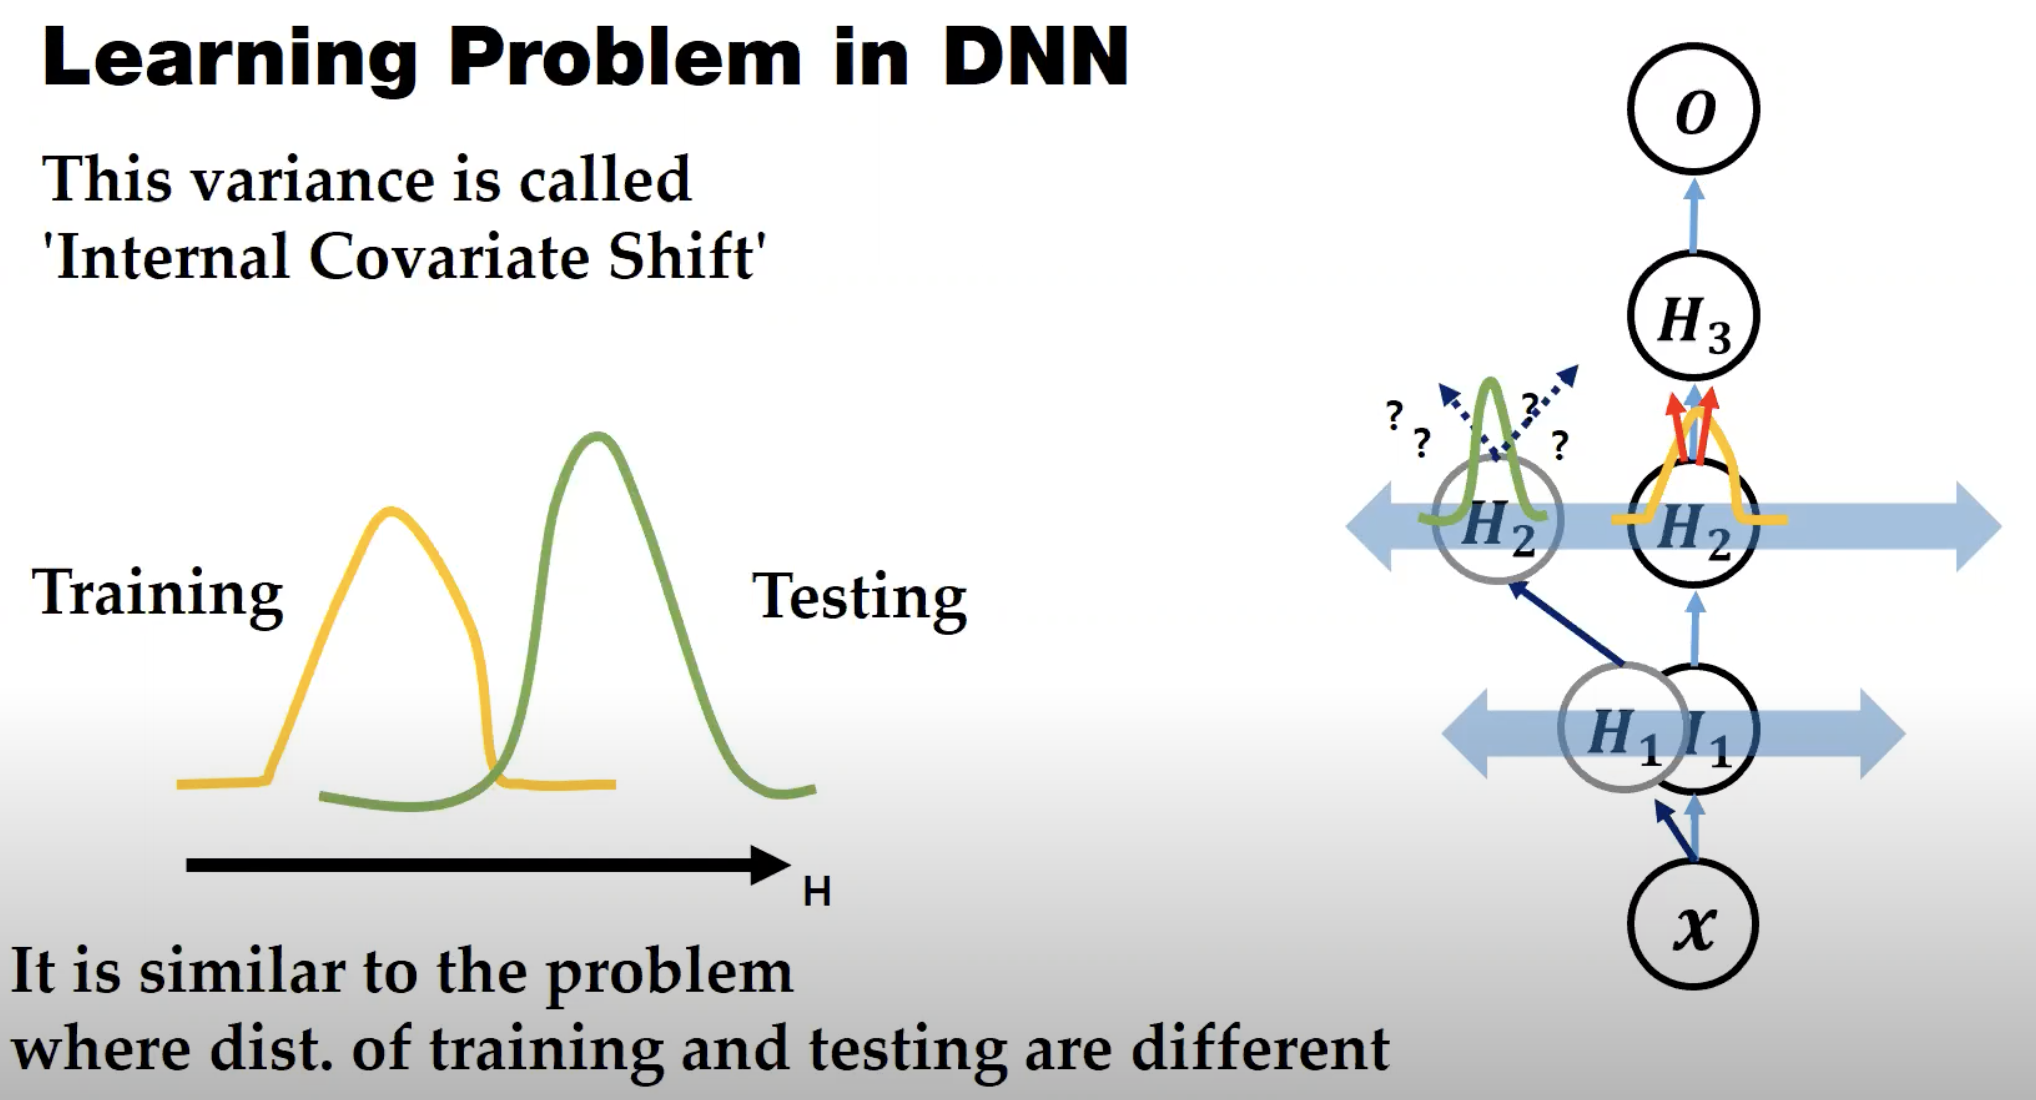

## Set Up

In [2]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 1. 배치 정규화(BN, Batch Normalization)

[05-1. 심층 신경망 학습](http://excelsior-cjh.tistory.com/177)에서는 활성화 함수로는 ReLU를 사용하고 He 초기화를 통해 학습 초기 단계에서의 그래디언트 소실/폭주 문제를 줄일 수 있었지만, 이러한 문제가 학습하는 동안에 또 다시 발생할 가능성이 있다.

2015년 Sergety Ioffe와 Christian Szegedy는 ['Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift'](https://arxiv.org/pdf/1502.03167v3.pdf)라는 논문에서 **배치 정규화**(BN, Batch Normalization)를 제안했다.  배치 정규화는 각 층의 활성화 함수의 출력값 분포가 골고루 분포되도록 '강제'하는 방법으로, 각 층에서의 활성화 함수 출력값이 정규분포(normal distribution)를 이루도록 하는 방법이다. 

즉, 학습하는 동안 이전 레이어에서의 가중치 매개변수가 변함에 따라 활성화 함수 출력값의 분포가 변화하는 **내부 공변량 변화(Internal Covariate Shift) 문제를 줄이는 방법**이 바로 배치 정규화 기법이다.

배치 정규화는 아래의 그림과 같이 미니배치(mini-batch)의 데이터에서 각 feature(특성)별 평균($\mu$, mean)과 분산($\sigma^{2}$, variance)을 구한 뒤 정규화(normalize) 해준다.

![](./images/bn.png)

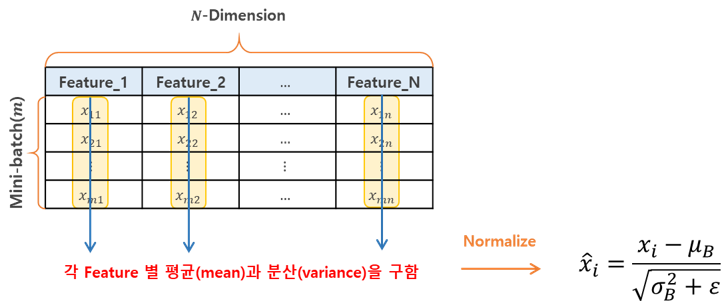 

일반적으로 배치 정규화는 아래의 그림과 같이 Fully Connected(FC)나 Convolutional layer 바로 다음, 활성화 함수를 통과하기 전에 **배치 정규화(BN)레이어**를 삽입하여 사용한다.

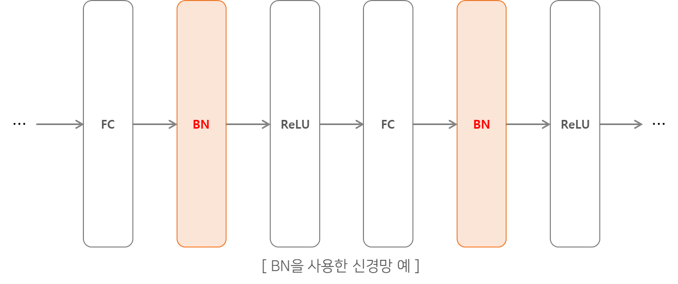



배치 정규화는 미니배치(mini-batch)를 단위로 **데이터의 분포가 평균($\mu$, mean)이 0**, **분산($\sigma^{2}$, variance)이 1**이 되도록 정규화(normalization)한다.  수식은 다음과 같다.

- **Input** : 미니배치 $B = \{ x_1, x_2, \dots, x_m \}$ 개의 입력 데이터, 학습 될 파라미터인 $\gamma, \beta$
- **Output** : $\{ y_i = \text{BN}_{\gamma, \beta}(x_i) \}$

$$
\begin{eqnarray*} \mu _{ B } & \leftarrow  & \frac { 1 }{ m } \sum _{ i=1 }^{ m }{ x_{ i } } & \text{// mini-batch mean}  \\ \sigma _{ B }^{ 2 } & \leftarrow  & \frac { 1 }{ m } \sum _{ i=1 }^{ m }{ \left( x_{ i }-\mu _{ B } \right) ^{ 2 } } & \text{// mini-batch variance}  \\ \hat { x } _{ i } & \leftarrow  & \frac { x_{ i }-\mu _{ B } }{ \sqrt { \sigma _{ B }^{ 2 }+\varepsilon }} & \text{// normalize} \\ y_{i} & \leftarrow & \gamma \hat{x}_{i} + \beta \equiv \text{BN}_{\gamma, \beta}(x_i) & \text{// scale and shift} \end{eqnarray*}
$$

- $\mu_B$ : 미니배치 $B$에 대한 평균
- $\sigma_B$ : 미니배치 $B$에 대한 표준편차
- $m$ : 미니배치 데이터 개수
- $\hat{x}_i$ : 평균이 0, 분산이 1로 정규화된 입력 데이터
- $\gamma$ : 정규화된 데이터에 대한 스케일(scale) 조정 파라미터
- $\beta$ : 정규화된 데이터에 대한 이동(shift) 조정 파라미터
- $\varepsilon$ : 분모가 0이 되는 것을 막기 위한 작은 숫자 ($10^{-5}$)
- $y_i$ : $\text{BN}$ 연산의 출력 결과 

### 1.1 Scale($\gamma$)과 Shift($\beta$)를 해주는 이유

위의 식에서 입력 데이터($x_i$)에 대해 정규화(normalization, $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2}+\varepsilon}}$)를 하게 되면, $\hat{x}_i$의 값이 대부분 0에 가까운 값이 될 것이다. 만약, 이러한 정규화된 입력 데이터 $\hat{x}_{i}$가 시그모이드(sigmoid) 활성화 함수의 입력값으로 들어가게 되면, 비선형(nonlinearity) 함수인 sigmoid가 선형(linearity)구간에 빠지게 된다(sigmoid 함수는 0 부근에서 선형성을 띤다). 이러한 문제를 해결하기 위해서 아래의 식과 같이 정규화된 입력 데이터 $x_i$에 scaling과 shifting해주는 $\gamma$와 $\beta$를 적용 해준다.

$$
y_i = \gamma \hat{x}_i + \beta
$$


 $\gamma$와 $\beta$를 다르게 표현하면 $\hat{x}_i$에 대한 가중치($\gamma$) 와 편향(bias, $\beta$)라고 볼 수 있으며,  $\gamma$와 $\beta$는 초기값으로 $\gamma=1, \beta=0$으로 시작해(즉, 초기에는 입력값 그대로 학습), 학습 과정에서 역전파(backprop)에 의해 적합한 값으로 조정된다.

 **ReLu, sigmoid에서 조금만 이동(scaling, shifting)하면 activation이 살아 있게 된다.**
**특히, sigmoid의 경우는, linear만 사용할수 있게 될수 있으므로, scaling, shifting을 해서,**
**non linear한 값을 사용할수 있도록 조정이 필요하다.**

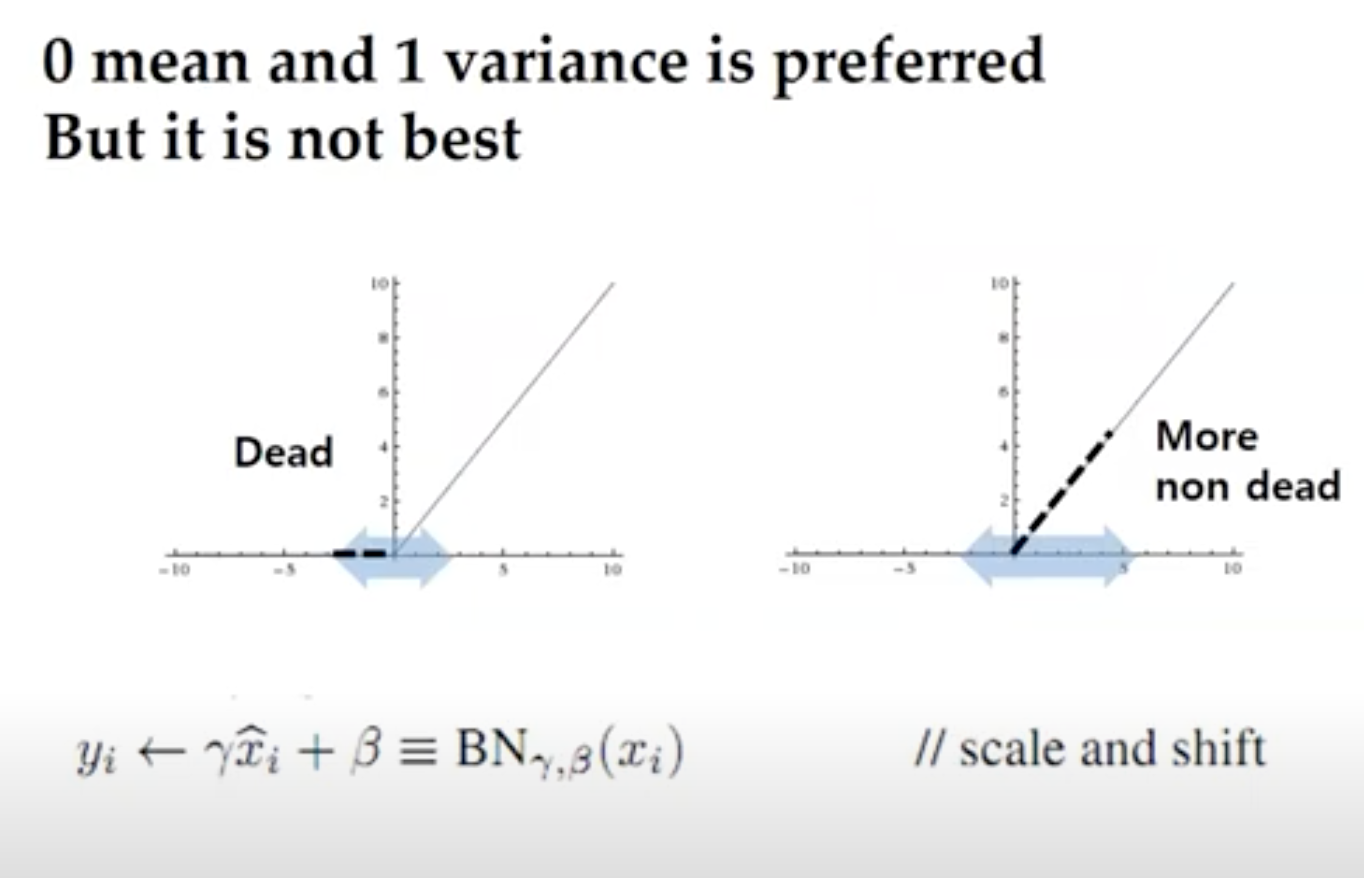

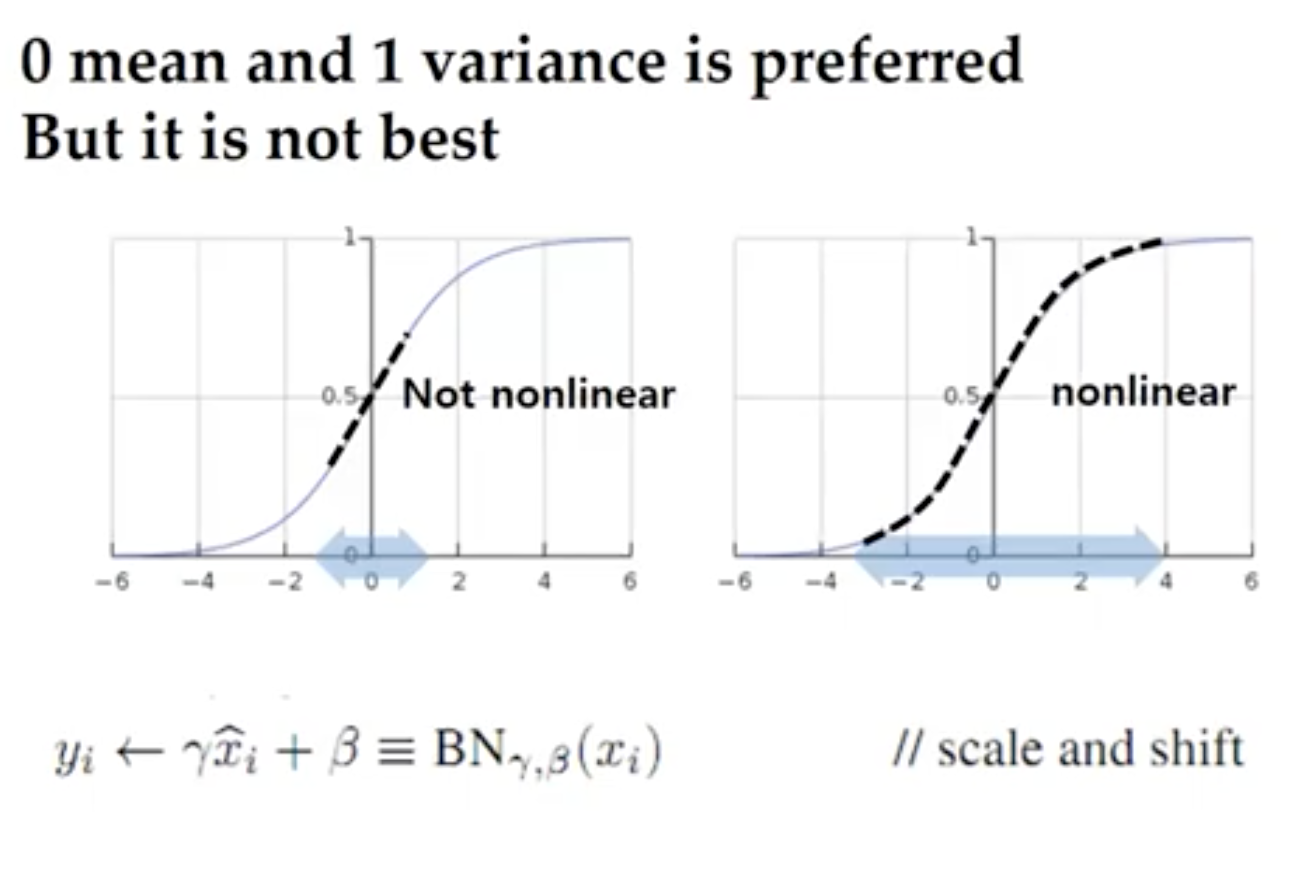

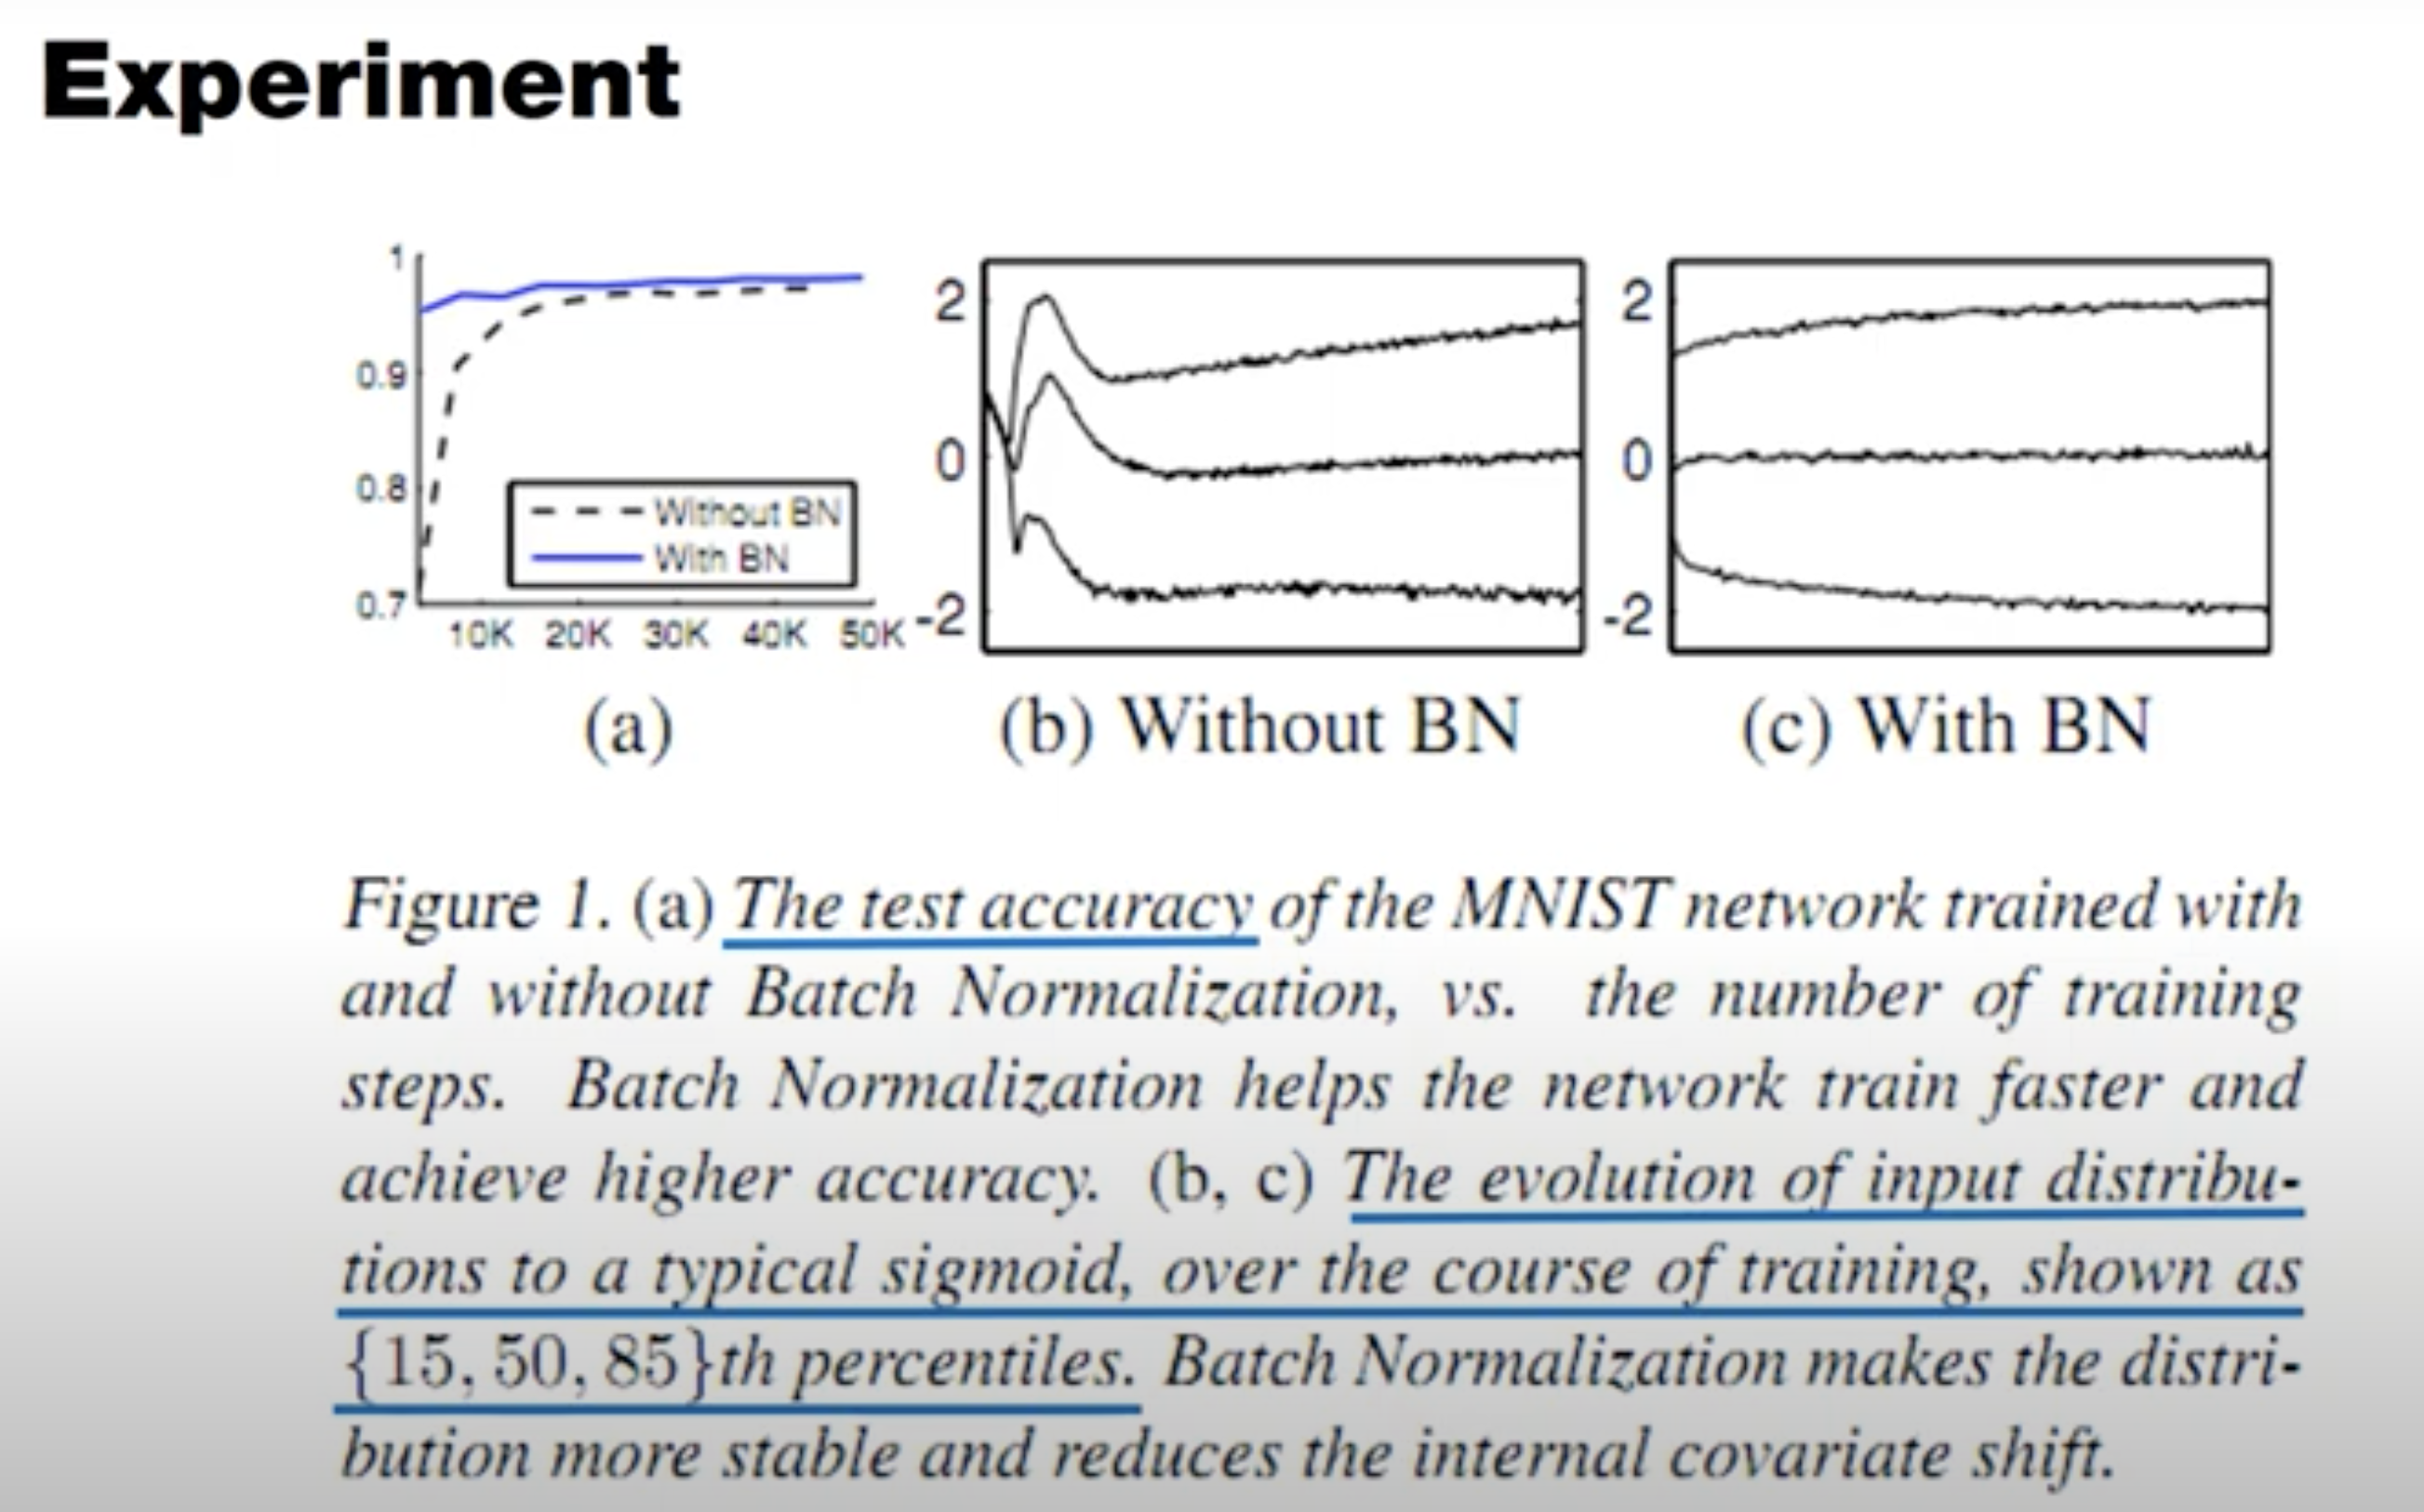

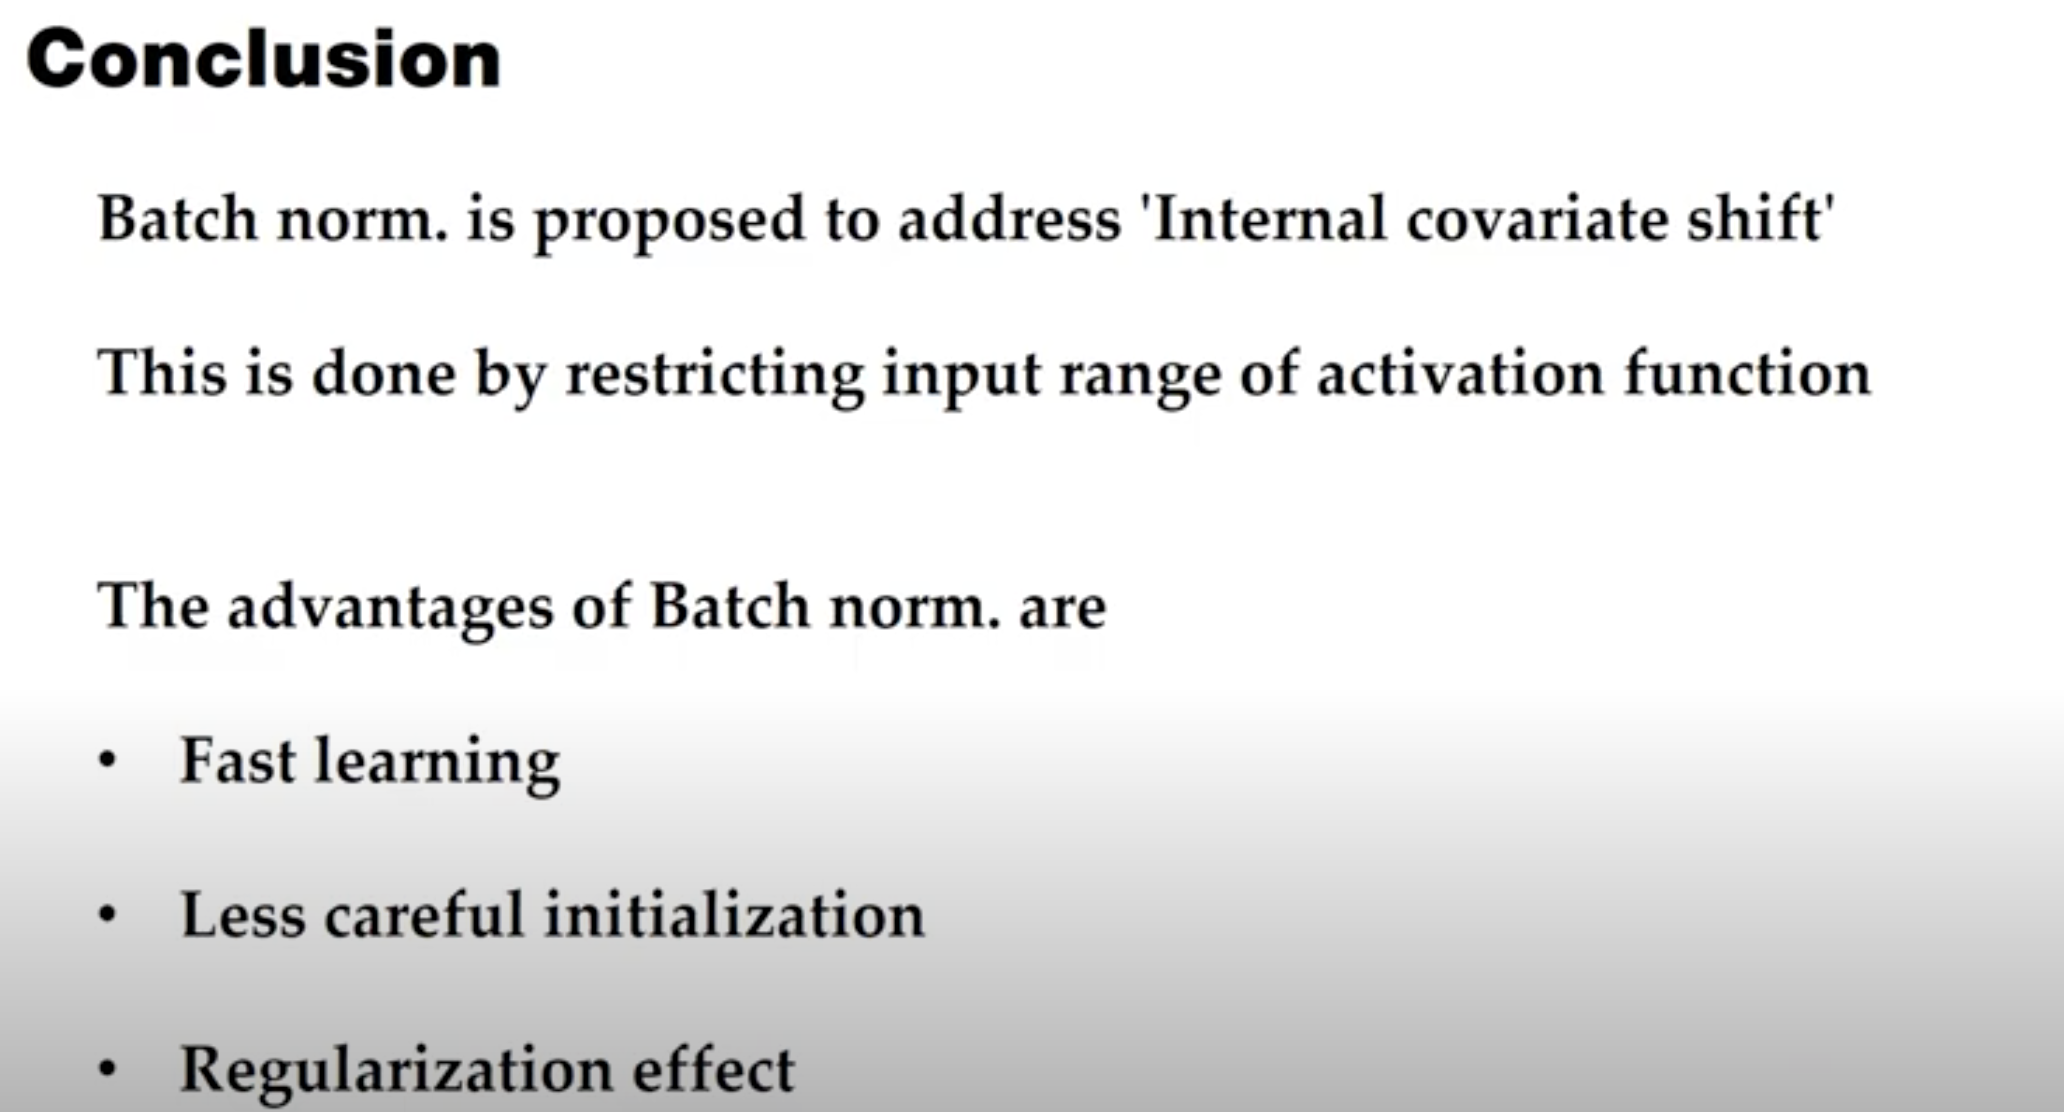

### 1.2 테스트(추론) 단계에서의 BN

테스트 단계(추론 단계처럼 데이터가 하나씩 주입된다고 가정)나 추론 단계에서는 평균($\mu_B$)과 표준편차($\sigma_{B}$)를 계산할 미니배치가 없기 때문에 **전체 Training Set의 평균과 표준편차를 사용**한다. 하지만, 엄청나게 많은 **전체 Training set에 대한 평균과 표준편차를 계산하기에는 무리기 때문에, 아래의 식과 같이 각 $n$개의 미니배치에 대한 평균과 표준편차를 이용해 전체 Training Set의 평균과 표준편차를 대신한다.**
$$
\begin{align*}
\hat{\mu} &= \frac{1}{n} \sum_{i=1}^{n}{\mu_{B}^{(i)}} \\ \hat{\sigma} &= \frac{1}{n} \sum_{i=1}^{n}{\sigma_{B}^{(i)}}
\end{align*}
$$
위와 같은 방법 대신, 모델 학습 단계에서 **지수 감소**(exponential decay) 이동 평균법(moving average)을 사용하여 평균과 표준편차를 계산할 수 있다. 

$$
\begin{align*}
\hat{\mu} & \leftarrow \alpha \hat{\mu} + \left(1 - \alpha \right)\mu_{B}^{(i)} & \text{// moving mean}\\ \hat{\sigma} & \leftarrow \alpha \hat{\sigma} + \left( 1 - \alpha \right) \sigma_{B}^{(i)} & \text{// moving stddev}
\end{align*}
$$

위의 식에서 $\alpha$는 모멘텀(momentum)값으로 일반적으로 1에 가까운 0.9, 0.99, 0.999로 설정한다.  이러한 moving mean과 moving stddev는 학습 단계에서 매 미니배치마다 업데이트 해준다.

### 1.4 텐서플로에서 Batch Normalization 구현하기

텐서플로(TensorFlow)에서는 [`tf.nn.batch_normalization()`](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization)과 [`tf.layers.batch_normalization()`](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)을 통해 두 개의 Batch Normalization을 제공한다. 하지만, `tf.nn.batch_normalization`은 평균과 표준편차(학습할 때는 미니배치, 테스트할 때는 전체 데이터셋)를 직접 계산한 뒤 인자로 전달해줘야 하며, scaling과 shifting을 위한 $\gamma, \beta$를 만들어 줘야한다. **반면, `tf.layers.batch_normalization`은 이러한 작업들을 모두 처리해 주기 때문에 이것을 사용하는 것이 좋다.** 

이제, `tf.layers.batch_normalization`을 이용하여 MNIST 데이터셋을 분류하는 DNN을 구현해 보도록 하자. DNN의 구성은 아래의 그림과 같이 784개의 입력층(input) → 300개 노드의 은닉층(hidden1) → 100개 노드의 은닉층(hidden2) → 10개의 출력층(output)으로 구성되어 있다.   

![](./images/bn03.png)


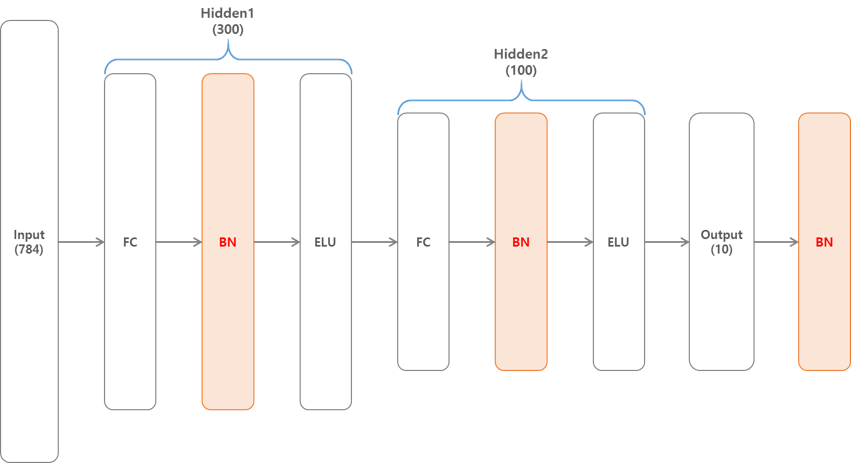 

#### 1) MNIST DataSet Load

먼저, 학습과 테스트에 사용할 MNIST 데이터셋을 로드한 뒤 랜덤하게 미니배치 크기만큼 가져오기 위한 `shuffle_batch()` 함수를 구현하자.

In [ ]:
import tensorflow as tf

# MNIST Load
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

# Train & TestSet reshape
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.
train_y = train_y.astype(np.int32)
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.
test_y = test_y.astype(np.int32)

# Split Validation set from Train set
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

In [ ]:
def shuffle_batch(inputs, labels, batch_size):
    rnd_idx = np.random.permutation(len(inputs))
    n_batches = len(inputs) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = inputs[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

**성능 실험은 위 그림 참조** 

#### 2) NN 구성하기

`tf.layers.batch_normalization()`처럼 배치 정규화가 반복해서 사용하기 때문에 코드 중복을 줄이기 위해 Python의 내장 모듈인 `functools`모듈 안에 있는 `partial()`함수를 사용해서 배치 정규화를 적용한다. 

`tf.layers.batch_normalization`로 배치 정규화를 사용할 경우, '1.2 테스트(추론) 단계에서의 BN'에서 살펴본 moving mean과 moving variance를 업데이트를 해주기 위해 [`tf.GraphKeys.UPDATE_OPS`](https://www.tensorflow.org/api_docs/python/tf/GraphKeys#UPDATE_OPS)를 사용해야 한다.

In [ ]:
from functools import partial

reset_graph()
################
# layer params #
################
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
batch_norm_momentum = 0.9

# input layer
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
# output layer
labels = tf.placeholder(tf.int32, shape=[None], name='labels')
# BN에 사용하기 위한 학습 유무
training = tf.placeholder_with_default(False, shape=[], name="training")

with tf.name_scope('dnn'):
    # batch normalization layer using partial
    batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training, 
            momentum=batch_norm_momentum)

    # 1st - hidden
    hidden1 = tf.layers.dense(inputs, n_hidden1, name="hidden1")
    # batch norm
    bn1 = batch_norm_layer(hidden1)
    # activation function
    bn1_act = tf.nn.elu(bn1)

    # 2nd - hidden
    hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
    bn2 = batch_norm_layer(hidden2)
    bn2_act = tf.nn.elu(bn2)

    # outputs
    logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
    logits = batch_norm_layer(logits_before_bn)
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')


################
# Hyper-params #
################
learning_rate = 0.01
n_epochs = 5
batch_size = 50

# moving mean & variance update
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(xentropy)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#### 3) 학습 시키기(Training)


In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels:batch_y, 
                                          training: True})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:03d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))

epoch: 000, valid. Acc: 0.9582
epoch: 001, valid. Acc: 0.9728
epoch: 002, valid. Acc: 0.9740
epoch: 003, valid. Acc: 0.9790
epoch: 004, valid. Acc: 0.9798


책에서는 Batch Norm이 심층 신경망에서 아주 널리 사용하고 있는 층이라, 보통 모든 층 뒤에 배치 정규화가 있다고 가정하므로, 종종 신경망 그림에 빠져있음.

**그러나 Hongyi Zhang등의 최근 논문에 따르면 배치 정규화없이 최고 성능을 달성한 사례가 존재한다.
(일부 논문에서는 ELU, SELU에서는 배치 정규화가 필요 없다고 얘기 하기도 함)**

## 2. 그래디언트 클리핑 (Gradient Clipping)

그래디언트 클리핑(Gradient Clipping)은 그래디언트 폭주(exploding gradient) 문제를 줄이는 방법이며, 역전파(backprop) 단계에서 그래디언트 값이 아래의 그림과 같이 특정 임계값(threshold)을 넘지 않도록 잘라내는 방법이다.

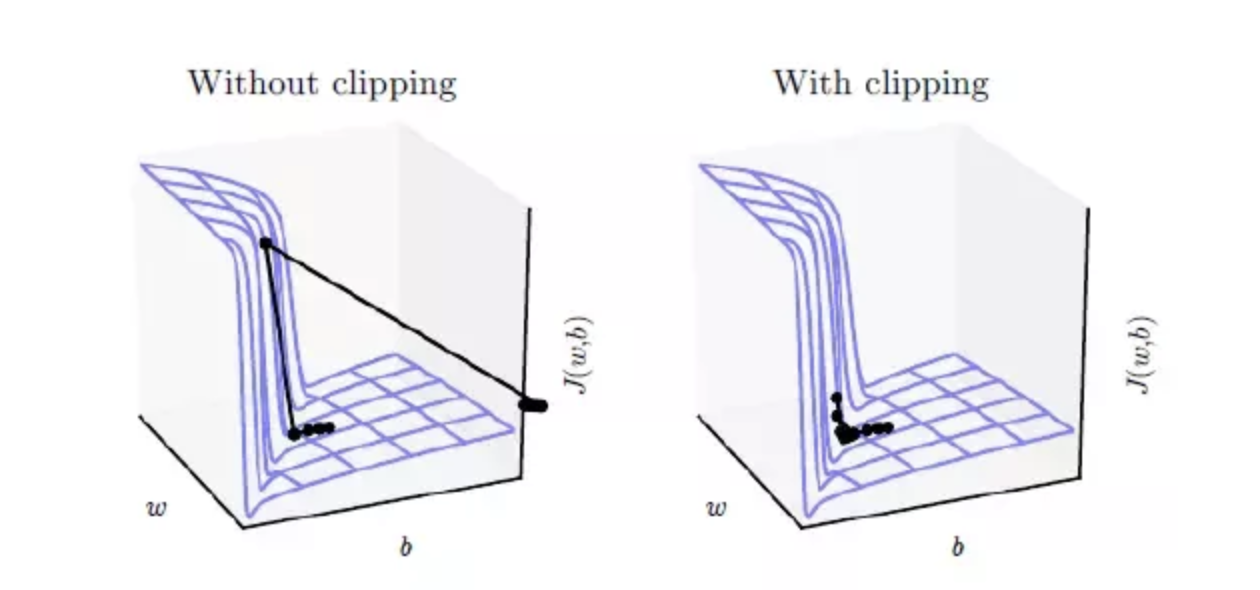

**순환 신경망은 배치 정규화 적용이 어려워 이 방법을 많이 사용한다.**

그래디언트 클리핑은 말 그대로 기울기 값을 자르는 것을 의미한다. 기울기 폭주를 막기 위해 임계값을 넘지 않도록 값을 자른다. 다시 말해서 임계치만큼 크기를 감소시키는 것이다. 이는 RNN에서 유용하다. RNN은 BPTT(Backpropagation Through Time)에서 시점을 역행하면서 기울기를 구하는데, 이때 기울기가 너무 커질 수 있기 때문입니다. 케라스에서는 다음과 같은 방법으로 그래디언트 클리핑을 수행.

```
from tensorflow.keras import optimizers
Adam = optimizers.Adam(lr=0.0001, clipnorm=1.)
```



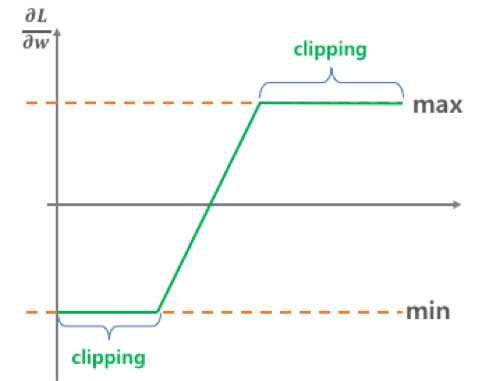

clipping이 없으면 gradient가 너무 뛰어서 global minimum에 도달하지 못하고 너무 엉뚱한 방향으로 향하게 되지만, 
clipping을 하게 되면 gradient vector가 방향은 유지하되 적은 값만큼 이동하여 도달하려고 하는 곳으로 안정적으로 내려가게 된다. 

### 2.1 텐서플로에서 그래디언트 클리핑 구현하기

텐서플로에서는 [`tf.clip_by_value`](https://www.tensorflow.org/api_docs/python/tf/clip_by_value)를 이용해 그래디언트 클리핑을 구현할 수 있다. 아래의 예제는 '1.4 텐서플로에서 Batch Normalization 구현하기'에서 사용한 MNIST 데이터셋을 분류하는 간단한 분류기를 구현한 뒤에 그래디언트 클리핑을 적용한 예제이다. 아래의 전체 코드는 [ExcelsiorCJH](https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap11-Training_DNN/Chap11_2-Training_DNN.ipynb) GitHub에서 확인할 수 있다.

 `tf.clip_by_value`를 사용하려면, 아래의 코드에서 옵티마이저(`tf.train.GradientDescentOptimizer`)에 사용해야 한다. '1.4 텐서플로에서 Batch Normalization 구현하기'에서는 옵티마이저의 `minimize()`함수를 이용해 그래디언트 계산과 적용을 처리 했다. 이러한 `minimize()`함수를 다음과 같이 두 가지 함수로 분리할 수 있다.

- 옵티마이저의 `compute_gradients()`함수를 이용해 먼저 그래디언트를 계산한다.
- 옵티마이저의 `apply_gradients()`함수에 `tf.clip_by_value()`를 적용하여 클리핑된 그래디언트를 적용한다.

In [ ]:
reset_graph()

################
# layer params #
################
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

# input layer
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
# output layer
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(inputs, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name='logits')
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
    
################
# Hyper-params #
################
learning_rate = 0.01
threshold = 1.0
n_epochs = 5
batch_size = 50

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # 그래디언트 계산
    grad_and_vars = optimizer.compute_gradients(loss)
    # 그래디언트 클리핑
    clipped_grads = [(tf.clip_by_value(grad, -threshold, threshold), var)
                     for grad, var in grad_and_vars]
    # 클리핑 된 그래디언트 적용
    train_op = optimizer.apply_gradients(clipped_grads)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            sess.run(train_op, feed_dict={inputs: batch_x, 
                                          labels:batch_y})
            
        # validation
        accuracy_val = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        print('epoch: {:03d}, valid. Acc: {:.4f}'.format(epoch, accuracy_val))

epoch: 000, valid. Acc: 0.9026
epoch: 001, valid. Acc: 0.9244
epoch: 002, valid. Acc: 0.9362
epoch: 003, valid. Acc: 0.9410
epoch: 004, valid. Acc: 0.9460


## **Summary**
### 기울기 소실(Gradient Vanishing)과 폭주(Exploding) 막는 법

1.  ReLU 사용하기
2. 그래디언트 클리핑(Gradient Clipping) : 기울기 폭주 막기위해 임계값을 정해놓음. RNN에서 유용
3. 가중치 초기화(Weight initialization) : 초기값을 무엇으로 설정하느냐에 따라 모델 훈련이 달라짐
  * 세이비어 초기화(Xavier Initialization) : 이전층 뉴런 개수와 다음층 뉴런 개수로 계산
  * He 초기화(He initialization) : 이전층 뉴런 개수만으로 계산
4. 배치 정규화(Batch Normalization)
* 내부 공변량 변화(Internal Covariate Shift) : 층마다 입력 데이터 분포가 달라짐
  * 배치 정규화(Batch Normalization) : 배치 단위로 정규화
  * 배치 정규화의 한계 : 미니 배치 크기에 의존적(배치크기 1로하면 분산 0), RNN 적용 힘듬(시점 마다 다른 통계치를 가져서)
  * 층 정규화 : 배치 정규화는 하나의 피쳐에 대한 데이터를 정규화 한다면 층 정규화는 obs당 정규화
5. 그래디언트 클리핑: 그래디언트 값을 특정 임계값(threshold)을 넘지 않도록 잘라내는 방법으로, 배치 정규화하기 힘든, RNN에서 많이 쓰임
